# Pre-Processing, Feature Engineering, and EDA (pp_fe_eda.ipynb)

### This notebook prepares retail sales data (100k records, 2019-2023, India stores) for the Retail Sales Prediction Dashboard. It includes:
## - **Data Cleaning**: Handle missing values, convert dates, remove duplicates.
## - **Feature Engineering**: Create Customer Age, CLV, Fulfillment Time, etc.
## - **EDA**: Visualize sales trends, regional performance, discount impacts, and correlations.
#
## Dataset: [Kaggle Store Sales Data](https://www.kaggle.com/datasets/abuhumzakhan/store-data)

# 1. Imports and Setup

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans

In [4]:
# Configure plotting style
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
# Define date columns
date_columns = ['Date of Birth', 'Sales Date', 'Order Date', 'Ship Date']

# 2. Load Data

In [6]:
# Load dataset
file_path = "/content/store_sales_data (2).csv"  # Update with your path
try:
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows, {len(df.columns)} columns")
except FileNotFoundError:
    print("Error: store_sales_data.csv not found!")
    df = None

Loaded 100000 rows, 25 columns


In [7]:
# Display first few rows
if df is not None:
    display(df.head())

,Customer ID,Customer Name,Last Name,Date of Birth,Sales,Year,Outlet Type,City Type,Category of Goods,Region,...,Ship Date,Ship Mode,State,Postal Code,Product ID,Sub-Category,Product Name,Quantity,Discount,Profit
0,CUST000001,Curtis,Krause,1973-11-29,3344.69,2023,Large,Tier 1,Fast Food,East,...,2020-04-18,Same Day,West Bengal,700001,PROD000001,Burgers,Burgers - 718,3,0.09,448.24
1,CUST000002,Jeremy,Foster,1987-08-30,37094.41,2022,Medium,Tier 2,Fast Food,East,...,2021-01-11,Standard Class,Punjab,160001,PROD000002,Pizzas,Pizzas - 519,5,0.39,3134.34
2,CUST000003,Ariel,Mccann,1980-12-15,35501.08,2023,Large,Village,Electric Appliances,South,...,2020-08-16,Second Class,Gujarat,380001,PROD000003,Fans,Fans - 395,6,0.07,8324.21
3,CUST000004,Colleen,Maynard,1989-05-23,8969.33,2021,Medium,Village,Dairy Products,East,...,2021-10-16,First Class,West Bengal,700001,PROD000004,Milk,Milk - 798,4,0.18,1962.66
4,CUST000005,Gina,Holden,1957-12-31,35530.44,2021,Small,Village,Sessional Fruits & Vegetables,West,...,2019-01-25,Standard Class,Delhi,110001,PROD000005,Tomatoes,Tomatoes - 442,4,0.27,2843.93


# 3. Data Cleaning

In [8]:
# Check data info
if df is not None:
    print("\nDataset Info:")
    print(df.info())

    # Check missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Drop rows with missing values (minimal impact: ~1 per column)
    df.dropna(inplace=True)

    # Convert date columns to datetime
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Drop rows with invalid dates
    df.dropna(subset=date_columns, inplace=True)

    # Verify date conversions
    print("\nDate Column Types:")
    print(df[date_columns].dtypes)
    print("\nMissing Dates:")
    print(df[date_columns].isnull().sum())

    # Drop duplicates
    df.drop_duplicates(inplace=True)
    print(f"\nCleaned dataset: {len(df)} rows remaining")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer ID        100000 non-null  object 
 1   Customer Name      100000 non-null  object 
 2   Last Name          100000 non-null  object 
 3   Date of Birth      100000 non-null  object 
 4   Sales              100000 non-null  float64
 5   Year               100000 non-null  int64  
 6   Outlet Type        100000 non-null  object 
 7   City Type          100000 non-null  object 
 8   Category of Goods  100000 non-null  object 
 9   Region             100000 non-null  object 
 10  Country            100000 non-null  object 
 11  Segment            100000 non-null  object 
 12  Sales Date         100000 non-null  object 
 13  Order ID           100000 non-null  object 
 14  Order Date         100000 non-null  object 
 15  Ship Date          100000 non-null  o

# 4. Feature Engineering

In [9]:
# Create new features
if df is not None:
    # Customer Age (years)
    df['Customer Age'] = (datetime.now() - df['Date of Birth']).dt.days // 365

    # Fulfillment Time (days)
    df['Fulfillment Time'] = (df['Ship Date'] - df['Order Date']).dt.days

    # Customer Lifetime Value (CLV): Total sales per customer
    df['CLV'] = df.groupby('Customer ID')['Sales'].transform('sum')

    # Discount Impact: Sales * Discount
    df['Discount Impact'] = df['Sales'] * df['Discount']

    # Product Popularity: Total quantity per product
    df['Product Popularity'] = df.groupby('Product ID')['Quantity'].transform('sum')

    print("\nNew Features Added:")
    print(df[['Customer Age', 'Fulfillment Time', 'CLV', 'Discount Impact', 'Product Popularity']].head())


New Features Added:
   Customer Age  Fulfillment Time       CLV  Discount Impact  \
0            51                 5   3344.69         301.0221   
1            37                 3  37094.41       14466.8199   
2            44                 5  35501.08        2485.0756   
3            35                 6   8969.33        1614.4794   
4            67                 3  35530.44        9593.2188   

   Product Popularity  
0                   3  
1                   5  
2                   6  
3                   4  
4                   4  


# 5. Encode Categorical Variables

In [10]:
# One-hot encode categorical columns
if df is not None:
    categorical_columns = ['Outlet Type', 'City Type', 'Category of Goods',
                         'Region', 'Country', 'Segment', 'Ship Mode',
                         'State', 'Sub-Category']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    print("\nEncoded Categorical Columns:")
    print(df.filter(like='Region_').columns.tolist())


Encoded Categorical Columns:
['Region_North', 'Region_South', 'Region_West']


#6. Exploratory Data Analysis (EDA

In [11]:
# Display summary stats
if df is not None:
    print("\nSummary Statistics:")
    display(df.describe())


Summary Statistics:


,Date of Birth,Sales,Year,Sales Date,Order Date,Ship Date,Postal Code,Quantity,Discount,Profit,Customer Age,Fulfillment Time,CLV,Discount Impact,Product Popularity
count,100000,100000.000000,100000.000000,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1984-03-06 03:10:31.584000128,25084.410142,2020.999910,2021-07-02 16:55:31.872000,2021-07-01 14:21:43.488000,2021-07-05 14:08:51.072000256,388985.180000,5.493760,0.251320,3755.305114,40.638060,3.991060,25084.410142,6304.045044,5.493760
min,1950-01-01 00:00:00,100.570000,2019.000000,2019-01-01 00:00:00,2019-01-01 00:00:00,2019-01-02 00:00:00,110001.000000,1.000000,0.000000,6.520000,6.000000,1.000000,100.570000,0.000000,1.000000
25%,1966-12-13 12:00:00,12618.030000,2020.000000,2020-04-03 00:00:00,2020-03-31 00:00:00,2020-04-04 00:00:00,226001.000000,3.000000,0.130000,1651.105000,23.000000,2.000000,12618.030000,1739.047725,3.000000
50%,1984-02-26 00:00:00,25134.695000,2021.000000,2021-07-01 00:00:00,2021-07-01 00:00:00,2021-07-06 00:00:00,380001.000000,5.000000,0.250000,3317.450000,41.000000,4.000000,25134.695000,4737.009900,5.000000
75%,2001-05-12 00:00:00,37575.850000,2022.000000,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-05 00:00:00,560001.000000,8.000000,0.380000,5363.845000,58.000000,6.000000,37575.850000,9623.969800,8.000000
max,2018-06-13 00:00:00,49999.890000,2023.000000,2023-12-31 00:00:00,2023-12-31 00:00:00,2024-01-07 00:00:00,700001.000000,10.000000,0.500000,14563.670000,75.000000,7.000000,49999.890000,24997.795000,10.000000
std,NaN,14403.187686,1.413757,NaN,NaN,NaN,184192.704685,2.876102,0.144324,2639.852035,19.833699,2.006554,14403.187686,5526.069561,2.876102


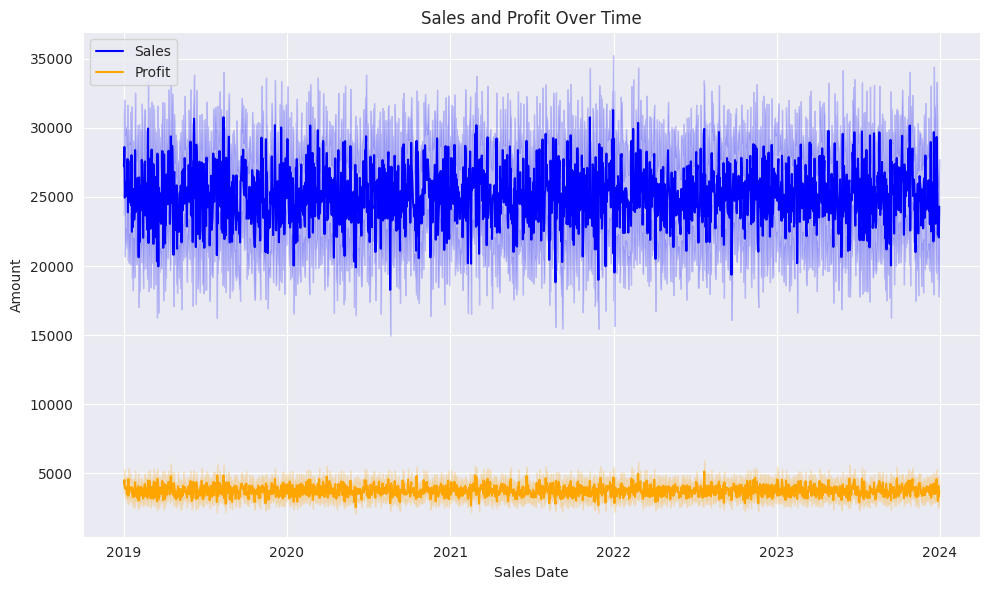

In [12]:
# Plot sales and profit trends
if df is not None:
    plt.figure()
    sns.lineplot(x='Sales Date', y='Sales', data=df, label='Sales', color='blue')
    sns.lineplot(x='Sales Date', y='Profit', data=df, label='Profit', color='orange')
    plt.title('Sales and Profit Over Time')
    plt.xlabel('Sales Date')
    plt.ylabel('Amount')
    plt.legend()
    plt.tight_layout()
    plt.show()

##Average Sales by Region

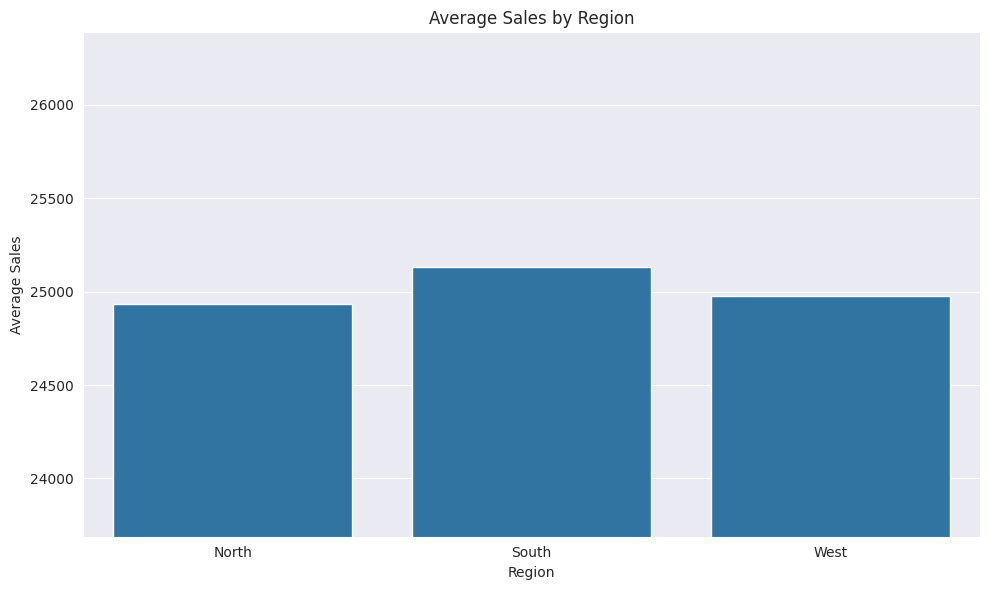

In [13]:
# Calculate and plot average sales by region
if df is not None:
    region_columns = [col for col in df.columns if col.startswith('Region_')]
    region_sales = {}
    for region in region_columns:
        region_sales[region] = df.loc[df[region] == 1, 'Sales'].mean()

    # Create DataFrame
    region_sales_df = pd.DataFrame(list(region_sales.items()),
                                  columns=['Region', 'Average Sales'])
    region_sales_df['Region'] = region_sales_df['Region'].str.replace('Region_', '')

    # Plot
    plt.figure()
    ax = sns.barplot(x='Region', y='Average Sales', data=region_sales_df)
    ax.set_ylim(region_sales_df['Average Sales'].min() * 0.95,
                region_sales_df['Average Sales'].max() * 1.05)
    plt.title('Average Sales by Region')
    plt.xlabel('Region')
    plt.ylabel('Average Sales')
    plt.tight_layout()
    plt.show()

## Discount vs. Profit

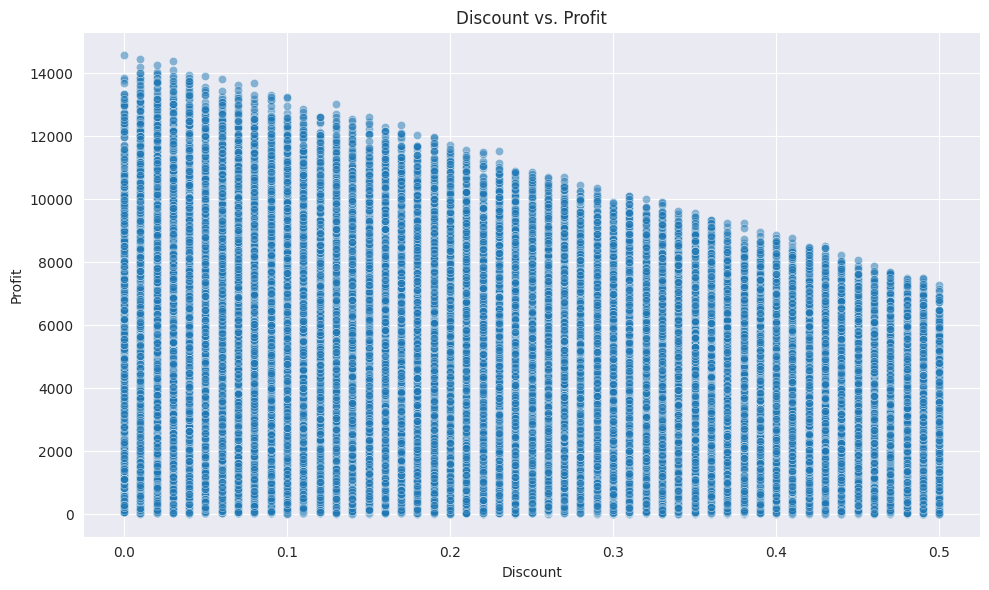

In [14]:
# Scatter plot of discount vs. profit
if df is not None:
    plt.figure()
    sns.scatterplot(x='Discount', y='Profit', data=df, alpha=0.5)
    plt.title('Discount vs. Profit')
    plt.xlabel('Discount')
    plt.ylabel('Profit')
    plt.tight_layout()
    plt.show()

##Sales Trends Over Time

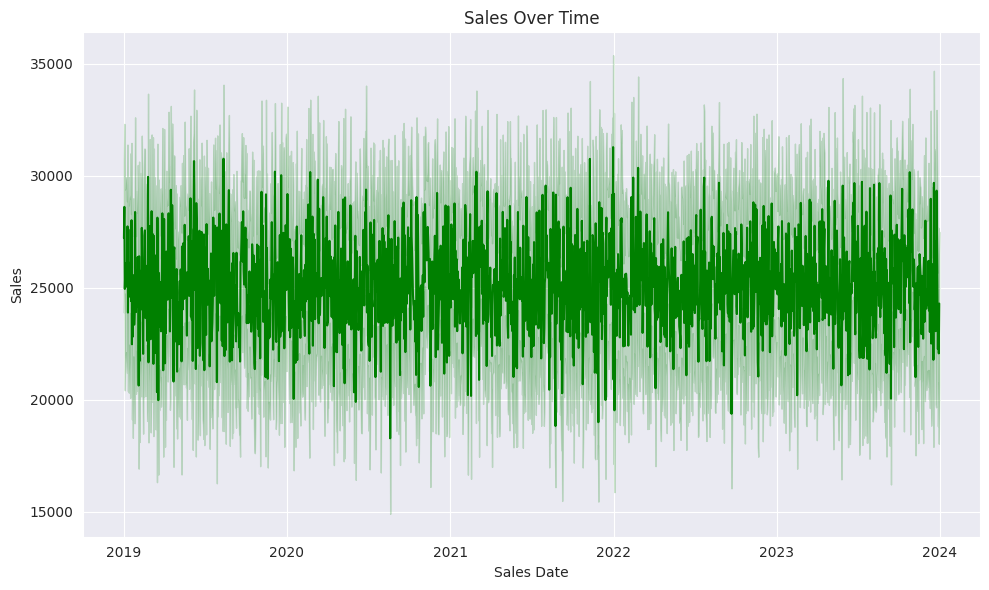

In [15]:
# Plot sales trend
if df is not None:
    plt.figure()
    sns.lineplot(x='Sales Date', y='Sales', data=df, color='green')
    plt.title('Sales Over Time')
    plt.xlabel('Sales Date')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()

##Correlation Heatmap

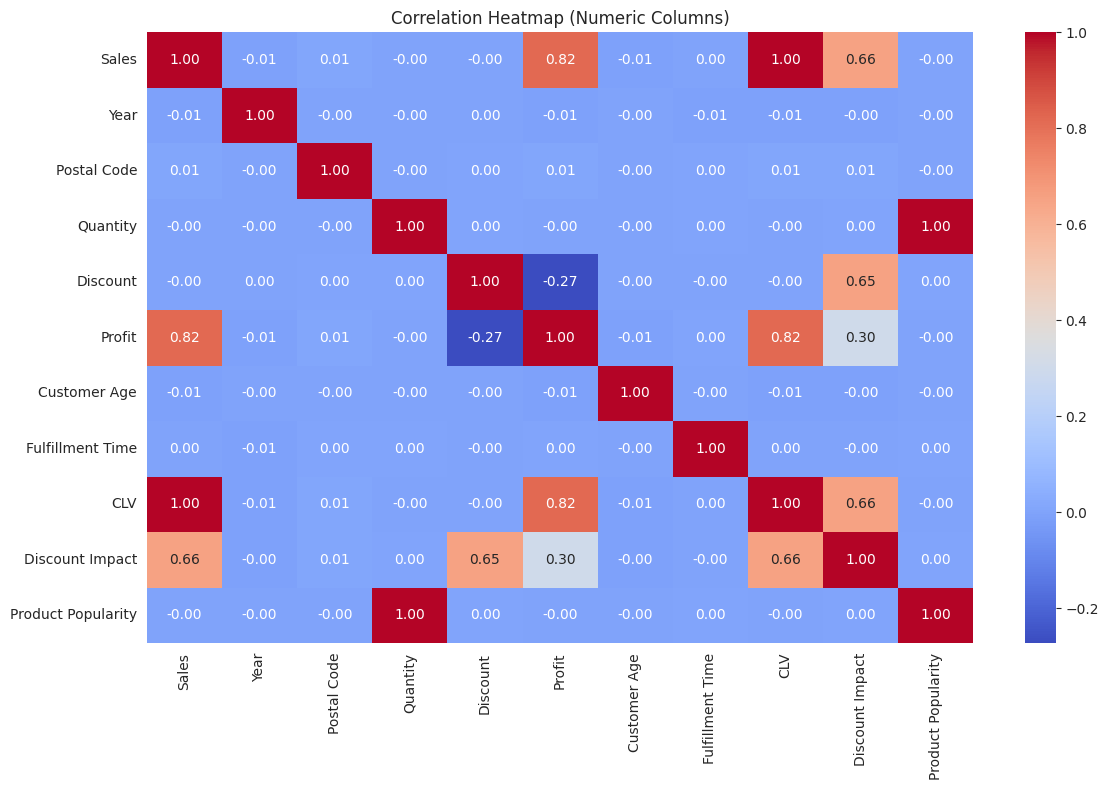

In [16]:
# Plot correlation heatmap for numeric columns
if df is not None:
    numeric_data = df.select_dtypes(include=['number'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap (Numeric Columns)')
    plt.tight_layout()
    plt.show()

##Customer Segmentation


Customer Segments:


,Customer ID,Total Sales,Order Frequency,Cluster
0,CUST000001,3344.69,1,3
1,CUST000002,37094.41,1,2
2,CUST000003,35501.08,1,2
3,CUST000004,8969.33,1,3
4,CUST000005,35530.44,1,2


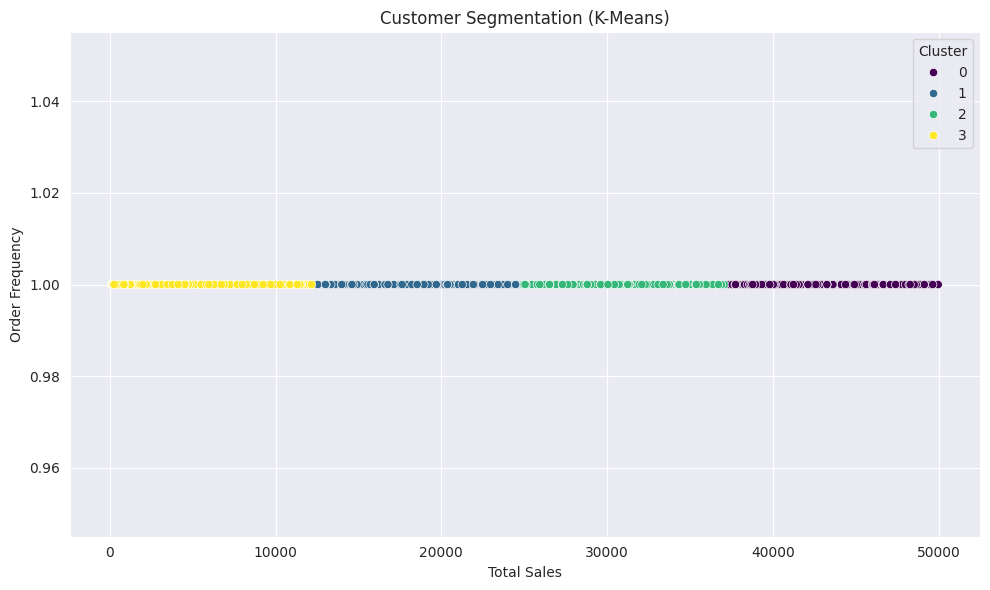

In [17]:
# K-Means clustering for customer segmentation
if df is not None:
    customer_data = df.groupby('Customer ID').agg({
        'Sales': 'sum',
        'Order ID': 'nunique'
    }).reset_index()
    customer_data.columns = ['Customer ID', 'Total Sales', 'Order Frequency']

    kmeans = KMeans(n_clusters=4, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(customer_data[['Total Sales', 'Order Frequency']])

    print("\nCustomer Segments:")
    display(customer_data.head())

    # Plot clusters
    plt.figure()
    sns.scatterplot(x='Total Sales', y='Order Frequency', hue='Cluster',
                    data=customer_data, palette='viridis')
    plt.title('Customer Segmentation (K-Means)')
    plt.tight_layout()
    plt.show()

## Profit Optimization

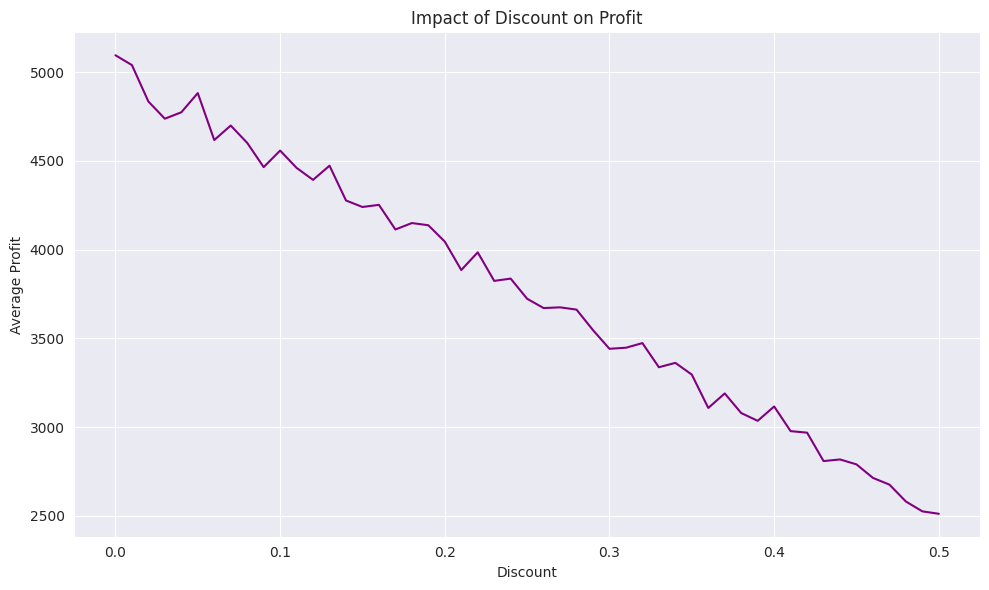

In [18]:
# Analyze discount impact on profit
if df is not None:
    discount_profit = df.groupby('Discount')['Profit'].mean().reset_index()
    plt.figure()
    sns.lineplot(x='Discount', y='Profit', data=discount_profit, color='purple')
    plt.title('Impact of Discount on Profit')
    plt.xlabel('Discount')
    plt.ylabel('Average Profit')
    plt.tight_layout()
    plt.show()

##Inventory Management

In [19]:
# Calculate safety stock
if df is not None:
    lead_time = 7  # days
    daily_sales = df.groupby('Sales Date')['Sales'].sum().mean()
    safety_stock = daily_sales * lead_time
    print(f"\nSafety Stock (based on {lead_time}-day lead time): {safety_stock:.2f}")


Safety Stock (based on 7-day lead time): 9616148.47


##Save Processed Data

In [20]:
# Save cleaned and engineered dataset
if df is not None:
    output_path = "processed_store_sales_data.csv"
    df.to_csv(output_path, index=False)
    print(f"\nSaved processed data to {output_path}")


Saved processed data to processed_store_sales_data.csv
